In [1]:
#Logan Kelsch + JJ
'''
/*
 *  taking this version of neural network training takes only a few features
 *          [ high, low, open, close, volume, TimeOfDay, DayOfWeek ]
 *  and uses common techniques described in 'features_creation.py' to largely
 *  expand dimensionality. 
 *  As of writing this (11/24/24) there is limited expansion
*/
''' 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from funcs_data_process import *
from feature_creation import *
from performance_printout import *
from tensorflow.keras.optimizers import AdamW


# Load the dataset
data = pd.read_csv('betaset_tmp.csv')

'''#---------------#
    MODEL VARIABLES
'''#---------------#


indp_size       = 0.1       #size of indepentendent set of samples
test_size       = 0.2       #size of validation set of samples
num_isol_feats  = 0         #number of features to be left out of PCA transformation
                            #   this function is depricated/needs updated
use_PCA         = True      #bool for use of PCA feature decomp. and transformation
comps_PCA       = 128        #number of primary components to use under PCA t.

time_steps      = 10        #LSTM time steps used

t_start         = 570       #start time for time based sample filtering         570 is 9:30am EST
t_end           = 645       #end   time for time based sample filtering         645,720 are 10:45am,12:00pm EST

params = model_params()
params = get_model_params(
    m_type          = 'Classification'      # {'Regression', 'Classification'}

   ,target_time     = 15        #how many minutes in the future is the target
   ,c_split_val     = 5
   ,c_class_cnt     = 2
)


#drop unused target columns
data = set_target(data, params)

#collect all sample indices to be kept through time filter
#two seperate functions to keep main and ind test isolated
keep_ndx = grab_wanted_times(data.values, t_start, t_end, time_steps)

#data = data.drop(columns=return_name_collection())
data = data.drop(columns=fn_orig_time())

#confirmation printout of all features/targets
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)


# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

params = update_class_weights(y, params)

y, label_encoder = y_preprocess(params, y)

X_nrm = normalize_from_tt_split(X, X, test_size)
if(use_PCA):
    X = reform_with_PCA_isolated(X_nrm, X_nrm, test_size, num_isol_feats, comps_PCA)
#X, y = reformat_to_lstm(X, y, time_steps)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))


print(f'Raw Sample Count:\t{len(X)}')
X,     y     = filter_times(X,     y,     keep_ndx)
print(f'Remaining Sample Count:\t{len(X)}')

#split all samples 3 ways into training, and testing
#   and split all testing into validation and independent
X_train, X_val, X_ind, y_train, y_val, y_ind =\
    split_into_train_val_ind(X, y, test_size, indp_size, time_steps)

inv_trn_y = label_encoder.inverse_transform(y_train)
params = update_class_weights(inv_trn_y, params)

print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_val shape == {}.'.format(X_val.shape))
print('y_val shape == {}.'.format(y_val.shape))
print('X_ind shape == {}.'.format(X_ind.shape))
print('y_ind shape == {}.\n'.format(y_ind.shape))



2024-12-12 23:04:43.461216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 23:04:43.612281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734062683.670129  549865 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734062683.687549  549865 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:04:43.828827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TARGET: tc_2c_15m
TESTED FEATURES: 
Index(['high', 'low', 'close', 'volume', 'ToD', 'DoW', 'vel1', 'vel2', 'vel3',
       'vel4',
       ...
       'hilo_stoch_120_30', 'hilo_stoch_120_60', 'hilo_stoch_120_120',
       'hilo_stoch_120_240', 'hilo_stoch_240_5', 'hilo_stoch_240_15',
       'hilo_stoch_240_30', 'hilo_stoch_240_60', 'hilo_stoch_240_120',
       'hilo_stoch_240_240'],
      dtype='object', length=518)
TESTING FOR: 
tc_2c_15m

X shape == (226576, 128).
y shape == (226576, 1).

Raw Sample Count:	226576
Remaining Sample Count:	12567

X_train shape == (8796, 128).
y_train shape == (8796,).
X_val shape == (2504, 128).
y_val shape == (2504,).
X_ind shape == (1247, 128).
y_ind shape == (1247,).



In [11]:
'''
    Here is the cool area of code, gonna try as many aeon things as possible to see what we can do
'''
from aeon.regression.convolution_based import HydraRegressor
from sklearn.metrics import accuracy_score

model = HydraRegressor(n_kernels=8, n_groups=16, random_state=42)#n_jobs=-1, random_state=None)

model.fit(X_train, y_train)

HydraRegressor(n_groups=16, random_state=42)

Training Accuracy: 0.6617780809458845


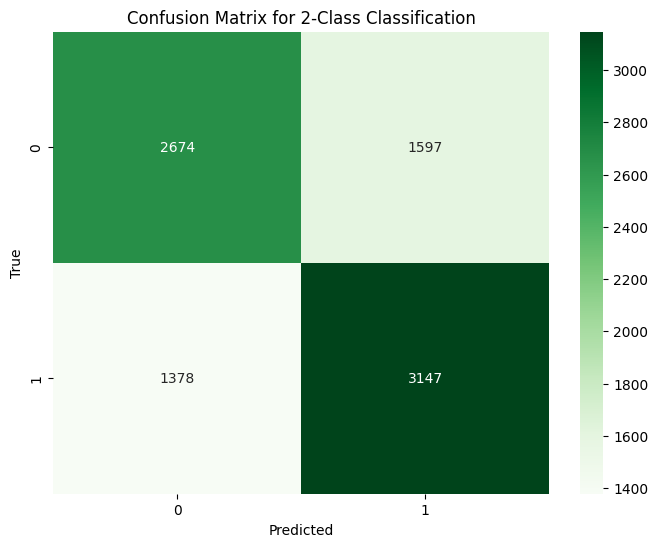

Training Accuracy: 0.4988019169329074


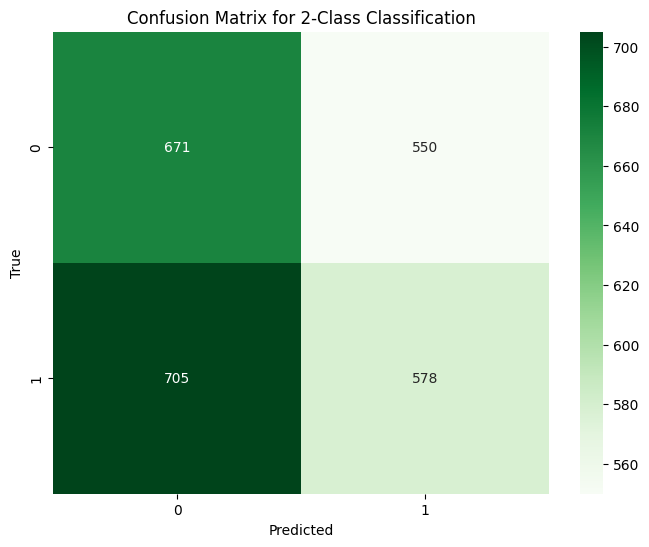

Training Accuracy: 0.5036086607858862


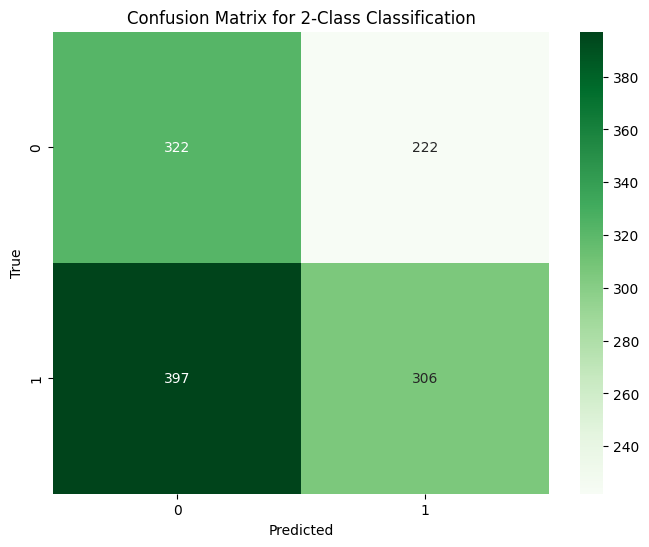

In [12]:
t = 0.5
y_pred = model.predict(X_train)
y_pred = y_pred > t
print(f'Training Accuracy: {accuracy_score(y_train, y_pred)}')
graph_predictions(y_pred, y_train, params, 'Training')
y_pred = model.predict(X_val)
y_pred = y_pred > t
print(f'Training Accuracy: {accuracy_score(y_val, y_pred)}')
graph_predictions(y_pred, y_val, params, 'validation')
y_pred = model.predict(X_ind)
y_pred = y_pred > t
print(f'Training Accuracy: {accuracy_score(y_ind, y_pred)}')
graph_predictions(y_pred, y_ind, params, 'independent')

In [4]:
y_train.ndim

2